In [107]:
#### TODO
# precision variables
# network without delay
# network with delay

In [108]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import random

path = os.getcwd().split(os.sep + 'Jacobian')[0]
if path not in sys.path:
    sys.path.append(path)

%load_ext autoreload
%autoreload 2

from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.models.wc import WCModel
from neurolib.models.aln import ALNModel

from neurolib.utils import jacobian as jac
from neurolib.utils import adjoint as adj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


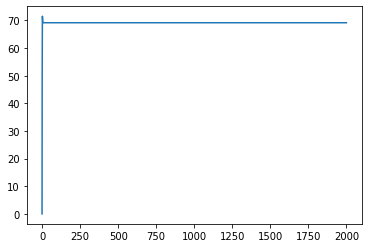

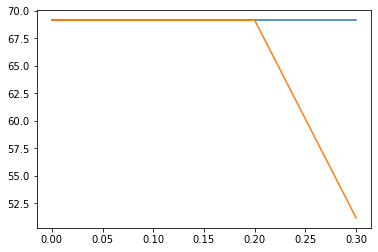

In [178]:
#model = FHNModel()
#model = HopfModel()
#model = WCModel()
model = ALNModel()

N = model.params.N

if model.name == 'aln':
    model.params.de = 0.
    model.params.di = 0.
    model.params.a = 0.
    model.params.b = 0.
    model.params.IA_init = np.zeros((N,))
    model.params.mue_ext_mean = 3.
    model.params.mui_ext_mean = 1.
    model.params.mue_ou = model.params.mue_ext_mean * np.ones((N,))
    model.params.mui_ou = model.params.mui_ext_mean * np.ones((N,))

dur0 = 2000.
dt = model.params.dt
T = int(dur0/dt)+1
V = len(model.state_vars)
model.params.duration = dur0
model.run()
init = adj.get_fullstate(model, model.state_vars, model.params.N, V, T)[:,:,-1]

plt.plot(model.t, model.rates_exc[0,:])
plt.show()

input_vars = model.input_vars
dur = 0.3
T = np.around(1+dur/dt,0).astype(int)
model.params.duration = dur
adj.set_init(model, init, model.init_vars, model.state_vars)
model.run()


start = adj.get_fullstate(model, model.state_vars, model.params.N, V, T)
plt.plot(model.t, start[0,0,:])

u0 = np.zeros(( N,len(input_vars),T ))
u_stim = np.zeros(( N,len(input_vars),T ))

v_control = np.array( [None] * N )
v_control[0] = [0]

if model.name in ['wc']:
    maxcontrol = 50.
else:
    maxcontrol = 5.

for t in np.arange(2, T-1, 1):
    for n in range(N):
        for v in v_control[n]:
            u_stim[n,v,t] = random.uniform( - 0.9 * maxcontrol, 0.9 * maxcontrol )

#u_stim[0,0,1] = 2.
                
for iv in range(len(input_vars)):
    model.params[input_vars[iv]] = u_stim[:,iv,:]

adj.set_init(model, init, model.init_vars, model.state_vars)
model.run()
target = adj.get_fullstate(model, model.state_vars, model.params.N, V, T)[:,:1,:]
plt.plot(model.t, target[0,0,:])
plt.show()


Initial cost =  161.24767962760092
adj =  [-33.0932085  -39.33376035 -46.5965153  -54.64657036]
-0.21444415978599807
-0.21444415978599807
-0.21444415978599807
-0.21444415978599807
direction  [ -7.09664529  -8.43489519  -9.99235057 -11.71863787]
direction  [-0. -0. -0. -0.]
1  cost =  34.402212843163944
adj =  [-29.148461   -38.21523629 -50.05965271 -60.4628297 ]
-0.21444415978599807
-0.142999253797349
-0.07345454899843062
-0.04457927949208518
direction  [-6.25071723 -5.46475027 -3.67710921 -2.69538938]
direction  [-0. -0. -0. -0.]
step size limit reached
iteration  1


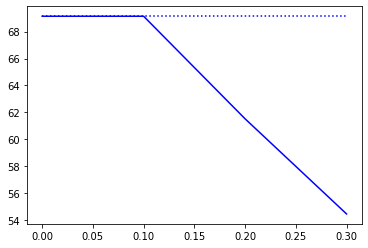

In [188]:
w = 0.
iterations = 10

u1, costlist1 = adj.opt_c(model, iterations, init, target, w, u0, v_control, maxcontrol, method='generic')

model.params.x_ext = u1[:,0,:]
model.params.y_ext = u1[:,1,:]

adj.set_init(model, init, model.init_vars, model.state_vars)
model.run()
state1 = adj.get_fullstate(model, model.state_vars, model.params.N, 2, T)
plt.plot(model.t, start[0,0,:], linestyle=':', color='blue')
plt.plot(model.t, state1[0,0,:], color='blue')
plt.show()

In [111]:
u2, costlist2 = adj.opt_c(model, iterations, init, target, w, u0, v_control, maxcontrol, method='analytic')

model.params.x_ext = u2[:,0,:]
model.params.y_ext = u2[:,1,:]

adj.set_init(model, init, model.init_vars, model.state_vars)
model.run()
state2 = adj.get_fullstate(model, model.state_vars, model.params.N, 2, T)
plt.plot(model.t, start[0,0,:], linestyle=':', color='blue')
plt.plot(model.t, state2[0,0,:], color='blue')
plt.show()

Initial cost =  1085.4673691179082
Analytic jacobian not implemented for aln model.
Analytic duh not implemented for aln model.


TypeError: bad operand type for unary -: 'NoneType'

In [166]:
adj.set_vartype(model)

generic_jac = jac.generic_jacobian(start[:,:,0], model)

analytic_jac = jacobian_analytic(V, start, u0, T, init)
for v in np.arange(10,13,1):
    print('generic = ', v, generic_jac[0,v,:])
    print('analytic  ', v, analytic_jac[v,:,0])

generic =  10 [ 0.00000000e+00  6.10554547e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.15774612e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.47158793e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
analytic   10 [ 0.00000000e+00 -6.10554547e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.40951562e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.47158793e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
generic =  11 [ 4.31402704e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.96377468e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.02983014e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+

In [132]:
from neurolib.utils.A1_aln_rate_control import jacobian

def jacobian_analytic(V, state_, control_, T, state_pre_):
    ext_exc_current = model.params.ext_exc_current
    ext_inh_current = model.params.ext_inh_current
    ext_ee_rate = model.params.ext_ee_rate
    ext_ei_rate = model.params.ext_ei_rate
    ext_ie_rate = model.params.ext_ie_rate
    ext_ii_rate = model.params.ext_ii_rate
    sigmae_ext = model.params.sigmae_ext
    sigmai_ext = model.params.sigmai_ext
    a = model.params["a"]
    b = model.params["b"]
    tauA = model.params["tauA"]
    C = model.params["C"]
    c_gl = model.params["c_gl"]
    Ke_gl = model.params["Ke_gl"]
    Ki_gl = model.params["Ki_gl"]
    Ke = model.params["Ke"]
    Ki = model.params["Ki"]
    tau_se = model.params["tau_se"] 
    tau_si = model.params["tau_si"] 
    cee = model.params["cee"]
    cei = model.params["cei"]
    cie = model.params["cie"]
    cii = model.params["cii"]
    Jee_max = model.params["Jee_max"]
    Jei_max = model.params["Jei_max"]
    Jie_max = model.params["Jie_max"]
    Jii_max = model.params["Jii_max"]
    taum = model.params.C / model.params.gL
    tau_se_sq = tau_se**2
    tau_si_sq = tau_si**2
    Jee_sq = Jee_max**2
    Jei_sq = Jei_max**2
    Jie_sq = Jie_max**2
    Jii_sq = Jii_max**2
    tau_ou = model.params.tau_ou
    N = model.params.N
    ndt_de = np.around(model.params.de / dt).astype(int)
    ndt_di = np.around(model.params.di / dt).astype(int)
    factor_ee1 = ( cee * Ke * tau_se / np.abs(Jee_max) )
    factor_ee2 = ( cee**2 * Ke * tau_se_sq / Jee_sq )
    factor_ei1 = ( cei * Ki * tau_si / np.abs(Jei_max) )
    factor_ei2 = ( cei**2 * Ki * tau_si_sq / Jei_sq )
    factor_ie1 = ( cie * Ke * tau_se / np.abs(Jie_max) )
    factor_ie2 = ( cie**2 * Ke * tau_se_sq / Jie_sq )
    factor_ii1 = ( cii * Ki * tau_si / np.abs(Jii_max) )
    factor_ii2 = ( cii**2 * Ki * tau_si_sq / Jii_sq )
    factor_eec1 = c_gl * Ke_gl * tau_se / np.abs(Jee_max)
    factor_eec2 = c_gl**2 * Ke_gl * tau_se_sq / Jee_sq 
    factor_eic1 = c_gl * Ki_gl * tau_si / np.abs(Jei_max)
    factor_eic2 = c_gl**2 * Ki_gl * tau_si_sq / Jei_sq 
    factor_iec1 = c_gl * Ke_gl * tau_se / np.abs(Jie_max)
    factor_iec2 = c_gl**2 * Ke_gl * tau_se_sq / Jie_sq 
    factor_iic1 = c_gl * Ki_gl * tau_si / np.abs(Jii_max)
    factor_iic2 = c_gl**2 * Ki_gl * tau_si_sq / Jii_sq

    rd_exc = np.zeros(( N,N, T ))
    rd_exc[0,0,:] = state_[0,0,:] * 1e-3
    rd_inh = np.zeros(( N, T ))
    rd_inh[0,:] = state_[0,1,:] * 1e-3
    
    sigmarange = model.params["sigmarange"]
    ds = model.params["ds"]
    Irange = model.params["Irange"]
    dI = model.params["dI"]
    precalc_r = model.params["precalc_r"]
    precalc_tau_mu = model.params["precalc_tau_mu"]
    precalc_V = model.params["precalc_V"]
    interpolate_rate = model.params["interpolate_rate"]
    interpolate_V = model.params["interpolate_V"]
    interpolate_tau = model.params["interpolate_tau"]

    return jacobian(V, state_, control_, T, state_pre_,
        ext_exc_current,
        ext_inh_current,
        ext_ee_rate,
        ext_ei_rate,
        ext_ie_rate,
        ext_ii_rate,
        sigmae_ext,
        sigmai_ext,
        a,
        b,
        tauA,
        tau_se,
        tau_si,
        Jee_max,
        Jei_max,
        Jie_max,
        Jii_max,
        tau_se_sq,
        tau_si_sq,
        Jee_sq,
        Jei_sq,
        Jie_sq,
        Jii_sq,
        taum,
        tau_ou,
        factor_ee1,
        factor_ee2,
        factor_ei1,
        factor_ei2,
        factor_ie1,
        factor_ie2,
        factor_ii1,
        factor_ii2,
        factor_eec1,
        factor_eec2,
        factor_eic1,
        factor_eic2,
        factor_iec1,
        factor_iec2,
        factor_iic1,
        factor_iic2,
        rd_exc,
        rd_inh,
        sigmarange, ds, Irange, dI,
        C,
        precalc_r, precalc_tau_mu, precalc_V,
        ndt_de,
        ndt_di,  
        interpolate_rate,
        interpolate_V,
        interpolate_tau
        )

In [52]:
maxdiff = 0.

for t in np.arange(10,10000, 1000):
    model = FHNModel()
    model.run()
    x = np.transpose(np.array( [model.x[:,t], model.y[:,t] ]))
    diff = jac.jacobian_fhn(x, model) - jac.generic_jacobian(x, model)
    if np.amax(np.abs(diff)) > maxdiff:
        maxdiff = np.amax(np.abs(diff))
        
print(maxdiff)

0.035262203839750095


In [ ]:
p.array( [model.x[:,t], model.y[:,t] ]))
    diff = jac.jacobian_fhn(x, model) - jac.generic_jacobian(x, model)
    if np.amax(np.abs(diff)) > maxdiff:
        maxdiff = np.amax(np.abs(diff))
        
print(maxdiff)

In [9]:
maxdiff = 0.

for t in np.arange(10,10000, 1000):
    model = HopfModel()
    model.run()
    x = np.transpose(np.array( [model.x[:,t], model.y[:,t] ]))
    diff = jac.jacobian_hopf(x, model) - jac.generic_jacobian(x, model)
    if np.amax(np.abs(diff)) > maxdiff:
        maxdiff = np.amax(np.abs(diff))
        
print(maxdiff)

0.01493902103071032


In [26]:
maxdiff = 0.
Tmax = 10000

for t in np.arange(10,Tmax, 1000):
    model = WCModel()
    model.params.exc_ext = np.zeros((N,Tmax ))
    model.params.inh_ext = np.zeros((N,Tmax ))
    u0 = model.params.exc_ext[:,t]
    u1 = model.params.inh_ext[:,t]
    model.run()
    x = np.transpose(np.array( [model.exc[:,t], model.inh[:,t] ]))
    diff = jac.jacobian_wc(x, model, u0, u1) - jac.generic_jacobian(x, model)
    if np.amax(np.abs(diff)) > maxdiff:
        maxdiff = np.amax(np.abs(diff))
        
print(maxdiff)

0.012288316362294383
